# Tutorial 03 - Analysing Estimated Data Sets

In this tutorial we will be analysing the results of the calculations which we performed in the [second tutorial](tutorial02.ipynb). 
The tutorial will cover:

- comparing the estimated data set with the experimental data set.
- plotting the two data sets. 

*Note: If you are running this example in google colab you will need to run a setup script instead of following the 
installation instructions:*

In [1]:
# !wget https://raw.githubusercontent.com/openforcefield/openff-evaluator/tutorials/docs/tutorials/colab_setup.ipynb
# %run colab_setup.ipynb

For the sake of clarity all warnings will be disabled in this tutorial:

In [2]:
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger("openforcefield").setLevel(logging.ERROR)

## Loading the Data Sets

We will begin by loading both the experimental data set and the estimated data set:

In [3]:
from evaluator.datasets import PhysicalPropertyDataSet

experimental_data_set_path = "filtered_data_set.json"
estimated_data_set_path = "estimated_data_set.json"

# If you have not yet completed the previous tutorials or do not have the data set files 
# available, copies are provided by the framework:

from evaluator.utils import get_data_filename
experimental_data_set_path = get_data_filename(
    "tutorials/tutorial01/filtered_data_set.json"
)
estimated_data_set_path = get_data_filename(
    "tutorials/tutorial02/estimated_data_set.json"
)

experimental_data_set = PhysicalPropertyDataSet.from_json(experimental_data_set_path)
estimated_data_set = PhysicalPropertyDataSet.from_json(estimated_data_set_path)

RDKit WARNING: [13:40:17] Enabling RDKit 2019.09.3 jupyter extensions


if everything went well from the previous tutorials, these data sets will contain the density and $H_{vap}$ of ethanol 
and isopropanol:

In [4]:
experimental_data_set.to_pandas().head()

,Temperature,Pressure,Phase,N Components,Component 1,Role 1,Mole Fraction 1,Exact Amount 1,Density Value,Density Uncertainty,EnthalpyOfVaporization Value,EnthalpyOfVaporization Uncertainty,Source
0,298.15 K,101.325 kPa,Liquid,1,CC(C)O,Solvent,1.0,None,782.7 kg / m ** 3,NaN,NaN,NaN,10.1016/j.fluid.2013.10.034
1,298.15 K,101.325 kPa,Liquid,1,CC(C)O,Solvent,1.0,None,NaN,NaN,45.34 kJ / mol,0.02 kJ / mol,10.1016/S0021-9614(71)80108-8
2,298.15 K,101.325 kPa,Liquid,1,CCO,Solvent,1.0,None,785.07 kg / m ** 3,NaN,NaN,NaN,10.1021/je1013476
3,298.15 K,101.325 kPa,Liquid,1,CCO,Solvent,1.0,None,NaN,NaN,42.26 kJ / mol,0.02 kJ / mol,10.1016/S0021-9614(71)80108-8


In [5]:
estimated_data_set.to_pandas().head()

,Temperature,Pressure,Phase,N Components,Component 1,Role 1,Mole Fraction 1,Exact Amount 1,Density Value,Density Uncertainty,EnthalpyOfVaporization Value,EnthalpyOfVaporization Uncertainty,Source
0,298.15 K,101.325 kPa,Liquid,1,CC(C)O,Solvent,1.0,None,0.8037040199927107 g / ml,0.00064094532111253 g / ml,NaN,NaN,SimulationLayer
1,298.15 K,101.325 kPa,Liquid,1,CC(C)O,Solvent,1.0,None,NaN,NaN,45.412329430981764 kJ / mol,0.20448559923210105 kJ / mol,SimulationLayer
2,298.15 K,101.325 kPa,Liquid,1,CCO,Solvent,1.0,None,0.79306223834769 g / ml,0.0006351508582454262 g / ml,NaN,NaN,SimulationLayer
3,298.15 K,101.325 kPa,Liquid,1,CCO,Solvent,1.0,None,NaN,NaN,39.48635367254331 kJ / mol,0.1367673630610498 kJ / mol,SimulationLayer


## Extracting the Results

We will now compare how the value of each property estimated by simulation deviates from the experimental measurement. 

To do this we will extract a list which contains pairs of experimental and evaluated properties. We can easily match 
properties based on the unique ids which were automatically assigned to them on their creation:

In [6]:
properties_by_type = {
    "Density": [],
    "EnthalpyOfVaporization": []
}

for experimental_property in experimental_data_set:

    # Find the estimated property which has the same id as the
    # experimental property.
    estimated_property = next(
        x for x in estimated_data_set if x.id == experimental_property.id
    )
    
    # Add this pair of properties to the list of pairs
    property_type = experimental_property.__class__.__name__
    properties_by_type[property_type].append((experimental_property, estimated_property))

## Plotting the Results

We will now compare the experimental results to the estimated ones by plotting them using `matplotlib`:

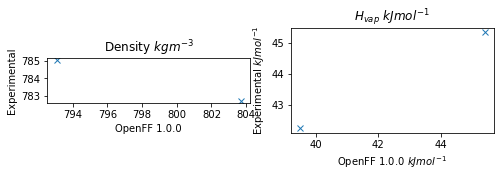

In [13]:
from matplotlib import pyplot

# Create the figure we will plot to.
figure, axes = pyplot.subplots(nrows=1, ncols=2, figsize=(8.0, 4.0))

# Set the axis titles
axes[0].set_xlabel('OpenFF 1.0.0')
axes[0].set_ylabel('Experimental')
axes[0].set_title('Density $kg m^{-3}$')

axes[1].set_xlabel('OpenFF 1.0.0 $kJ mol^{-1}$')
axes[1].set_ylabel('Experimental $kJ mol^{-1}$')
axes[1].set_title('$H_{vap}$ $kJ mol^{-1}$')

# Define the preferred units of the properties
from evaluator import unit

preferred_units = {
    "Density": unit.kilogram / unit.meter ** 3,
    "EnthalpyOfVaporization": unit.kilojoule / unit.mole
}

for index, property_type in enumerate(properties_by_type):

    experimental_values = []
    estimated_values = []

    preferred_unit = preferred_units[property_type]

    # Convert the values of our properties to the preferred units.
    for experimental_property, estimated_property in properties_by_type[property_type]:
        
        experimental_values.append(
            experimental_property.value.to(preferred_unit).magnitude
        )
        estimated_values.append(
            estimated_property.value.to(preferred_unit).magnitude
        )

    axes[index].plot(
        estimated_values, experimental_values, marker='x', linestyle='None'
    )
    axes[index].set_aspect('equal', 'box')

## Conclusion

And that concludes the third tutorial. 